# Chi-Squared Test

Here, we generate samples of the chi-squared test statistic using i.i.d standard normal variates.

Based on the demonstration in an online forum [[link](https://stats.stackexchange.com/questions/16921/how-to-understand-degrees-of-freedom)]


In [1]:
%matplotlib inline
%load_ext cython

# Import requisite modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2


In [2]:
# Run parameters
seed = 22
numVariates = 20 # Number of i.i.d normal variates per repetition for the Chi-squared test
numRepetitions = 10000 # Number of repetitions of bin counts for the Chi-squared test
quantiles = [0.0, 0.25, 0.5, 0.75, 1.0] # Quantiles for binning the simulated data

In [3]:
# Simulations
np.random.seed(seed) # Make simulation repeatable with seed parameter
data = np.random.normal(size=(numRepetitions, numVariates)) # Generate numRepetitions x numVariates i.i.d standard normals


In [4]:
# Intermediate quantities
bins = [norm.ppf(b) for b in quantiles]


In [5]:
#%%cython -a
#import numpy as np

# This function returns an array, with each entry being the chi-squared statistic computed for the 
def ComputeChiSquaredStatisicsNaive(data, bins):
    numRepetitions = np.shape(data)[0]
    numVariates = np.shape(data)[1]
    
    means = np.mean(data, axis=1) # For each repetition, determine the arithmetic mean of the variates
    stdvs = np.std(data, axis=1)  # For each repetition, determine the standard deviation of the variates
    
    # For each repetition, determine the expected count in each bin, according to the computed means and stdvs
    expected = np.diff(np.array([norm.cdf(b, loc=means, scale=stdvs) for b in bins]), axis=0).T * numVariates

    # For each repetition, determine the observed count in each bin from the simulation data
    observed = np.array([np.histogram(data[i], bins=bins)[0] for i in range(numRepetitions)])
    
    # For each repetition, compute the chi-squared statistic
    output = np.sum((observed - expected) ** 2 / expected, axis=1)
    
    return output
            


In [6]:
# Results of the chi-squared test based on simulations
chiSquaredResults = ComputeChiSquaredStatisics(data, bins)

# Overlay plots with theoretical PDFs for X^2(1) and X^2(2) plots
chiSquaredX = np.linspace(0.0, 20.0, 1000)
chiSquared1 = chi2.pdf(chiSquaredX, 1)
chiSquared2 = chi2.pdf(chiSquaredX, 2)

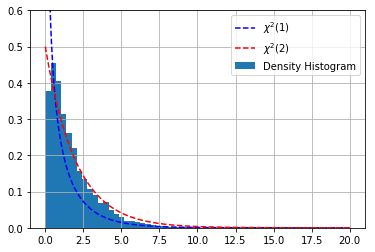

In [7]:
_, _, _ = plt.hist(chiSquaredResults, bins=50, density=True)
plt.plot(chiSquaredX, chiSquared1, 'b--')
plt.plot(chiSquaredX, chiSquared2, 'r--')
plt.ylim([0.0, 0.6])
plt.grid()
plt.legend(['$\chi^2(1)$', '$\chi^2(2)$', 'Density Histogram'])

## Likelihood function for counts

The distribution of interest is the **normal** distribution:
$$X = \mathcal{N}(z|\mu, \sigma)$$

In our case, we have the four quartile intervals for the standard normal, $I_1=(-\infty, -0.67]$, $I_2=(-0.67, 0]$, $I_3=(0, +0.67]$ and $I_4=(+0.67, +\infty)$. With $
\theta=[\mu,\sigma]$, the probabilities in each case are $q_1(\theta) = \Phi\left( \dfrac{-0.67-\mu}{\sigma} \right)$, $q_2(\theta)=\Phi\left( \dfrac{0-\mu}{\sigma} \right)-\Phi\left( \dfrac{-0.67-\mu}{\sigma} \right)$, $q_3(\theta)=\Phi\left(\dfrac{+0.67-\mu}{\sigma} \right)-\Phi\left(\dfrac{0.0-\mu}{\sigma} \right)$ and $q_4(\theta)=1.0 - \Phi\left( \dfrac{+0.67-\mu}{\sigma} \right)$.

A single sample from $X$ falling into one of the four interval bins is a **categorical** random variable with probability $q_j$ for the $j^{th}$ category, $j \in 1,2,3,4$.

The distribution for $N$ samples is the distribution of a **sum** of $N$ i.i.d categorical variables. This is a **multinomial** distribution with parameters $N$ and $q_j, j \in 1,\ldots,4$. The likelihood function is then:

$$L(\mu, \sigma) = p\left([c_1,c_2,c_3,c_4]|N,\mu,\sigma\right)=\dfrac{n!}{c_1!c_2!c_3!c_4!} \prod_{j=1}^4 q_j(\mu, \sigma)^{x_j}$$

For convenience, we write the log-likelihood as:
$$f(\mu,\sigma) = \ln L(\mu, \sigma)=\text{constant} + \sum_{j=1}^4 c_j \ln q_j(\mu, \sigma)$$

The maximum likelihood, or **MLE**, parameters are given by:
$$(\hat{$$

The probability of a single sample from $X$ occurring in an interval $I$ is a Bernoulli random variable with parameter, say, $q$. Here, $q$ is the probability of the indicator function of $I$ under $X$, i.e., $q = \mathbb{P}_X(\mathbb{1}_I)$.

The probability distribution of the counts in the interval $I$ for $N$ samples of $X$ follows the distribution of the sum if $N$ Bernoulli variables of paramter $q$. This is a binomial distribution with parameters $N$ and $q$.


The likelihood function for an observation of a quadruple of counts is the product of three independent binomial likelihood functions: the fourth is inferred from the sum constraint, i.e., all counts must sum to $N$. So, we have for the likelihood function:

$$L \equiv L([c_1, c_2, c_3, N-(c_1+c_2+c_3)]; \mu, \sigma, N) = BINOMIAL(c_1|q,N) \times BINOMIAL(c_2|q,N) \times BINOMIAL(c_3|q,N)= f_1 \times f_2 \times f_3$$

Here, 
$$f = BINOMIAL(k|q,N) = {n \choose k} q^k (1-q)^{n-k}$$

We prefer working with the log-likelihood for convenience:
$$\ln f = \ln ^nC_k + k\ln q + (n-k)\ln(1-q) $$

It follows that:
$$\ln L(\theta) = \sum_{j=1}^3 \left[\ln {N \choose c_j} + c_j \ln q_j(\theta) + (N-c_j)\ln(1-q_j(\theta)) \right]$$
This function may be maximized to obtain the MLE parameters, $\hat{\theta} = [\hat{\mu}, \hat{\sigma}] = \arg\max_{\theta} \ln L(\theta)$.
